In [1]:
import geopandas as gpd
import pandana as pdna
import osmnet
import numpy as np
import pandas as pd
import seaborn as sns

# Build a zone-zone distance matrix

In [2]:
zones=gpd.read_file('../outputs/zones.geojson').set_index('GEOID')

In [3]:
zones.columns

Index(['Com_Name', 'Dist_Name', 'Com_ID', 'Dist_ID', 'Level', 'Pop_2009',
       'Pop_2019', 'Den_2009', 'Den_2019', 'Shape_Leng', 'area',
       'res_income_1', 'res_income_2', 'res_income_3', 'res_income_4',
       'res_total', 'emp_naics_11', 'emp_naics_21', 'emp_naics_23',
       'emp_naics_48-49', 'emp_naics_52', 'emp_naics_61', 'emp_naics_62',
       'emp_naics_72', 'emp_naics_81', 'emp_naics_92', 'emp_total',
       'x_centroid', 'y_centroid', 'sim_area', 'model_area', 'reference_area',
       'geometry'],
      dtype='object')

In [4]:
zones['sqrt_area']=np.sqrt(zones['area'])

In [5]:
bbox=zones.total_bounds
nodes_df,edges_df=osmnet.load.network_from_bbox(lat_min=bbox[1], lng_min=bbox[0], lat_max=bbox[3], 
                          lng_max=bbox[2], bbox=None, network_type='drive', 
                          two_way=True, timeout=180, 
                          custom_osm_filter=None)

/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](10.35422539,106.35645091,10.75916709,106.69244657);>;);out;'}"
Downloaded 36,568.1KB from www.overpass-api.de in 6.45 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](10.75751660,106.35645091,11.16049711,106.69473891);>;);out;'}"
Downloaded 41,156.1KB from ww

In [6]:
net=pdna.Network(nodes_df["x"], nodes_df["y"],edges_df["from"], edges_df["to"],
                 edges_df[["distance"]])

In [7]:
# G=ox.graph_from_polygon(zones.unary_union, network_type='drive')

In [8]:
centroids=zones['geometry'].centroid
zones['x_centroid']=[c.x for c in centroids]
zones['y_centroid']=[c.y for c in centroids]

<ipython-input-8-7a8af156ee5d>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=zones['geometry'].centroid


In [9]:
nearest_nodes=net.get_node_ids(zones['x_centroid'], zones['y_centroid'])

In [12]:
dist_mat=[]
for o in range(len(zones)):
    origin_list=[nearest_nodes[o]]*len(nearest_nodes)
    dest_list=nearest_nodes
    all_dist_from_o = net.shortest_path_lengths(origin_list, dest_list, 'distance')
    all_dist_from_o[o]=zones.iloc[o]['sqrt_area']/2
    dist_mat.append(all_dist_from_o)

In [13]:
dist_mat_df=pd.DataFrame(dist_mat)
dist_mat_df.index=zones.index
dist_mat_df.columns=zones.index

In [14]:
dist_mat_df

GEOID,26734,26740,26752,26746,26755,26761,26758,26749,27121,27124,...,26896,26902,26893,26872,27472,26787,26875,26898,26897,26881
GEOID,,,,,,,,,,,,,,,,,,,,,
26734,397.962973,2419.987000,4020.999000,3511.903000,4478.745000,5014.547,4203.168,3702.211,778.000,1481.056,...,3551.058,3802.367,4430.261,9445.126,7806.556,10736.294000,6526.244000,8549.224000,9128.395000,9824.1960
26740,2419.987000,787.089672,2181.880000,1672.784000,2639.626000,3364.345,2898.841,2286.628,2541.633,2831.657,...,5151.784,5852.593,6172.533,11495.352,5967.437,12691.148000,8530.645000,10599.450000,11178.621000,11874.4220
26752,4020.999000,2181.880000,238.271812,762.437000,471.710000,1499.466,1463.681,1006.673,3590.149,2743.948,...,7223.090,7114.406,7742.300,12757.165,3814.580,12362.654000,9838.283000,11861.263000,12440.434000,11974.2970
26746,3511.903000,1672.784000,762.437000,350.871285,1168.875000,2000.289,2046.342,1396.232,3139.575,2618.930,...,6713.994,6766.416,7394.310,12409.175,4294.653,12640.177000,9490.293000,11513.273000,12092.444000,12251.8200
26755,4478.745000,2639.626000,471.710000,1168.875000,298.188269,1151.696,1030.005,970.788,4008.426,3162.225,...,7680.836,7328.127,7956.021,12970.886,4286.290,12548.477000,10052.004000,12074.984000,12654.155000,12160.1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26787,10736.294000,12691.148000,12362.654000,12640.177000,12548.477000,12957.671,12146.292,11737.127,10397.341,10464.265,...,9291.315,8398.753,8428.121,4927.137,16177.234,670.756904,7237.138000,4035.834000,4380.005000,4082.9780
26875,6526.244000,8530.645000,9838.283000,9490.293000,10052.004000,10461.198,9649.819,9240.654,6417.942,7210.500,...,3583.756,2723.877,2728.741,3515.979,13652.863,7237.138000,538.968336,3552.174000,3491.351000,5031.4000
26898,8549.224000,10599.450000,11861.263000,11513.273000,12074.984000,12484.178,11672.799,11263.634,8440.922,9233.480,...,5633.415,4746.857,4775.136,2064.646,15675.843,4035.834000,3552.174000,540.069746,1033.199000,1661.1760


In [15]:
dist_mat_df.to_csv('../outputs/zone_to_zone_dist_mat.csv')

# O-D Analysis

In [16]:
simpop_df=pd.read_csv('../outputs/simpop.csv')
simpop_df['work_geoid']=simpop_df['work_geoid'].astype(int).astype(str)
simpop_df['home_geoid']=simpop_df['home_geoid'].astype(int).astype(str)

In [17]:
od=simpop_df.groupby(['home_geoid','work_geoid']).size()

In [18]:
attractions=simpop_df.groupby('work_geoid').size()
generations=simpop_df.groupby('home_geoid').size()

In [19]:
def get_value_from_df_default(df, ind):
    try:
        return df.loc[ind[0], ind[1]]
    except:
        return 0

In [20]:
all_geoids=list(zones.index)

In [21]:
C, trips, trips_to, trips_from= [], [], [], []
for o_geoid in all_geoids:
    for d_geoid in all_geoids:
        c=dist_mat_df.loc[o_geoid, d_geoid]
        t=get_value_from_df_default(od,[o_geoid, d_geoid])
        if ((c<1e6) and (t>0)):
#             pop.append(zones.loc[o_geoid, 'Pop_2019'])
            trips_from.append(generations.loc[o_geoid])
            trips_to.append(attractions.loc[d_geoid])
            trips.append(t)
            C.append(c)      

## Gravity Model

$t_{ij} = \frac{t_j U_i C_{ij}^{\beta_1}}{\sum_{k}U_k C_{kj}^{\beta_1}} $

$t_{ij}/t_j = \beta_0 U_i C_{ij}^{\beta_1} $

Where:
- Cij is impedance (network distance)
- t_ij is trips from i to j
- tj is all trips to j
- Ui is residential attractiveness (capacity) at i
- beta0 and beta1 are calibration parameters

In [22]:
t_norm=[trips[i]/(trips_to[i]*trips_from[i]) for i in range(len(trips))]

## Trips vs Distance

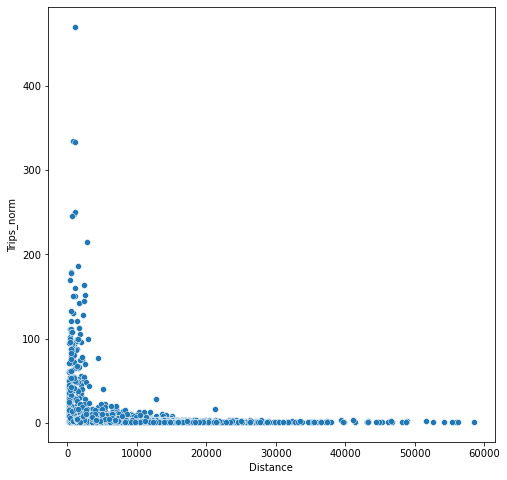

In [23]:
plt.figure(figsize=(8,8))
splot=sns.scatterplot(x=C, y=trips)
result=splot.set(
#     xscale="log", yscale="log", 
    xlabel='Distance', ylabel='Trips_norm')

# Log(Trips_norm) vs Log(Distance)

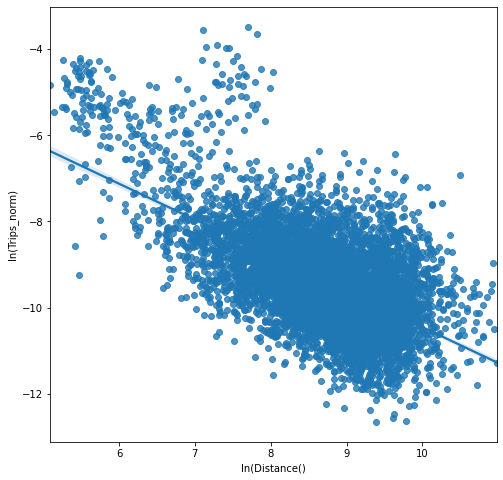

In [34]:
plt.figure(figsize=(8, 8))
splot=sns.regplot(x=np.log(C), y=np.log(t_norm))
result=splot.set(
#     xscale="log", yscale="log", 
    xlabel='ln(Distance()', ylabel='ln(Trips_norm)')

In [25]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
y=np.log(t_norm)
x=np.log(C).reshape(-1, 1)

regr = linear_model.LinearRegression()

regr.fit(x, y)

LinearRegression()

### Predictions

In [27]:
# y_pred = np.dot(np.dot(np.exp(regr.predict(x)), trips_to), pop)
log_t_norm_pred = regr.predict(x)
t_norm_pred = np.exp(log_t_norm_pred)
t_pred=np.multiply(t_norm_pred,
                   np.multiply(trips_to, trips_to))

In [33]:
# plt.figure(figsize=(12,12))
# jp=sns.jointplot(np.divide(trips, trips_to), 
#                  np.divide(t_pred, trips_to))
# jp.set_axis_labels('Actual Home Portion', 'Predicted Home Portion', fontsize=16)
# jp.ax_marg_x.set_xlim(0, 0.1)
# jp.ax_marg_y.set_ylim(0, 0.1)

### Actual vs Predicted

/Users/doorleyr/anaconda3/envs/pandana/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 864x864 with 0 Axes>

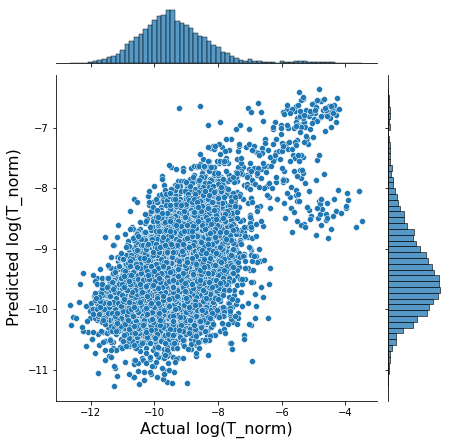

In [32]:
plt.figure(figsize=(12,12))
jp=sns.jointplot(y, log_t_norm_pred)
jp.set_axis_labels('Actual log(T_norm)', 'Predicted log(T_norm)', fontsize=16)
# jp.ax_marg_x.set_xlim(0, 0.1)
# jp.ax_marg_y.set_ylim(0, 0.1)

### Model Summary

In [31]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, log_t_norm_pred))

Coefficients: 
 [-0.83198048]
Coefficient of determination: 0.37
